# 프로젝트: 네이버 영화 리뷰 감성분석

#### **프로젝트 개요**  

**1. 프로젝트 목적:**  


한국어 영화 리뷰 텍스트에서 **긍정/부정 감성을 자동으로 분류**하는 딥러닝 모델을 구현하고, 다양한 모델 아키텍처와 사전학습 임베딩의 효과를 비교 분석한다.  


**2. 데이터셋: 🍿 [Naver Sentiment Movie Corpus v1.0 (NSMC)](https://github.com/e9t/nsmc)**  
- 훈련 데이터: 약 150,000개
- 테스트 데이터: 약 50,000개
- 레이블: 0 (부정) |  1 (긍정)


**3. 모델:**  

- 기본 모델 4가지 (자체 학습된 임베딩 사용)
   
  * **RNN:** Embedding(128) → RNN(256, 2층) → FC → Sigmoid
  * **LSTM:** Embedding(128) → LSTM(256, 2층) → FC → Sigmoid
  * **1D CNN:** Embedding(128) → Conv1D(3,4,5 filters) → MaxPool → FC → Sigmoid
  * **Global Max Pooling:** Embedding(128) → GlobalMaxPool → FC → Sigmoid    
- 사전 학습 모델 4가지 (사전 학습된 임베딩 한국어 Word2Vec 임베딩 사용)
  * 기본 모델과 동일 구조 + 사전학습 임베딩
 
**5. 프로젝트 수행 절차**  

[STEP 1] 데이터 전처리  
[STEP 2] 자체학습 임베딩 활용 모델 훈련 및 성능 비교  
[STEP 3] 최고 성능 모델의 임베딩 레이어 분석  
[STEP 4] 사전학습 임베딩 활용 모델 훈련 및 성능 비교

## 0. 라이브러리 불러오기 & 경로 설정

In [1]:
# PyTorch 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence

# 자연어 처리
import konlpy
from konlpy.tag import Mecab
import gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from sklearn.manifold import TSNE # 임베딩 레이어 시각화
from sklearn.metrics.pairwise import cosine_similarity # 임베딩 레이어 코사인 유사도 계산

# 헬퍼 라이브러리
import os
import random
import pickle # 모델 저장
from collections import Counter
import pandas as pd # 데이터 처리
import numpy as np
import matplotlib.pyplot as plt # 시각화
import matplotlib.font_manager as fm # 폰트 관리

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 버전 확인
print("라이브러리 버전 확인")
print("=" * 30)
print(f"pandas version: {pd.__version__}")
print(f"konlpy version: {konlpy.__version__}")
print(f"gensim version: {gensim.__version__}")

라이브러리 버전 확인
pandas version: 2.3.0
konlpy version: 0.6.0
gensim version: 4.3.2


In [2]:
# 데이터 경로 설정
DATA_DIR = os.path.join(os.getenv("HOME"), 'work/sentiment_classification/data')

## 1. 데이터 준비

In [3]:
# 데이터 읽기
train_data = pd.read_table(os.path.join(DATA_DIR, 'ratings_train.txt'))
test_data = pd.read_table(os.path.join(DATA_DIR, 'ratings_test.txt'))

In [4]:
# 데이터 크기 확인
print(f"훈련 데이터: {len(train_data):,}개")
print(f"테스트 데이터: {len(test_data):,}개")

훈련 데이터: 150,000개
테스트 데이터: 50,000개


In [5]:
# 훈련 데이터 샘플 확인
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
# 데이터 정보 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [7]:
# 결측치 확인
print(f"훈련 데이터 결측치:\n{train_data.isnull().sum()}개")
print(f"\n테스트 데이터 결측치:\n{test_data.isnull().sum()}개")

훈련 데이터 결측치:
id          0
document    5
label       0
dtype: int64개

테스트 데이터 결측치:
id          0
document    3
label       0
dtype: int64개


In [8]:
# 레이블 분포 확인
print(train_data['label'].value_counts())

label
0    75173
1    74827
Name: count, dtype: int64


## 2. 데이터 로더 구성

In [9]:
def load_data(train_data, test_data, tokenizer, stopwords, num_words=10000):
    """
    네이버 영화 리뷰 감성 분석 데이터셋(NSMC)을 IMDB 데이터셋 형식으로 변환하는 함수
    전처리 과정: 
    중복 제거, 
    토큰화, 
    불용어 처리, 
    인덱스 인코딩 과정

    Args:
        train_data: 훈련 데이터 DataFrame
        test_data: 테스트 데이터 DataFrame
        tokenizer: 한국어 토크나이저 (예: Mecab())
        stopwords: 불용어 리스트
        num_words: 사전에 포함할 최대 단어 수 (default: 10000)
    
    Returns:
        X_train: 훈련 데이터 (인덱스 시퀀스 리스트)
        y_train: 훈련 레이블 (numpy array)
        X_test: 테스트 데이터 (인덱스 시퀀스 리스트)
        y_test: 테스트 레이블 (numpy array)
        word_to_index: 단어-인덱스 매핑 딕셔너리
    """
    
    print("\n" + "=" * 60)
    print("데이터 전처리 시작")
    print("=" * 60)
    
    # 중복된 리뷰 제거
    # 'document' 컬럼을 기준으로 중복된 내용이 있다면 하나만 남기고 모두 삭제
    print("\n 중복 제거...")
    train_before = len(train_data)
    test_before = len(test_data)
    
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    print(f"  훈련: {train_before:,} → {len(train_data):,} ({train_before - len(train_data):,}개 제거)")
    print(f"  테스트: {test_before:,} → {len(test_data):,} ({test_before - len(test_data):,}개 제거)")
    
    # 결측치(Null) 제거
    # 리뷰 내용이 비어있는(NaN) 행이 있을 경우 학습에 오류가 발생하므로 제거
    print("\n NaN 결측치 제거...")
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')
    print(f"  최종 훈련: {len(train_data):,}개")
    print(f"  최종 테스트: {len(test_data):,}개")

    # 빈 문장 제거
    print("\n 빈 문장 제거...")
    
    # 토큰화 전에 빈 문장이나 너무 짧은 문장 제거
    train_data = train_data[train_data['document'].str.len() > 0]
    test_data = test_data[test_data['document'].str.len() > 0]
    
    print(f"  훈련 데이터: {len(train_data):,}개")
    print(f"  테스트 데이터: {len(test_data):,}개")
    
    # 형태소 토큰화 및 불용어 제거
    print("\n토큰화 중...")
    print("  (시간이 좀 걸릴 수 있습니다...)")
    
    X_train = []
    y_train_temp = []
    
    for idx, (sentence, label) in enumerate(zip(train_data['document'], train_data['label'])):
        # 진행 상황 확인용 출력 (10,000회에 한 번)
        if idx % 10000 == 0:
            print(f"    훈련 데이터 진행: {idx}/{len(train_data)} ({idx/len(train_data)*100:.1f}%)")
        
        temp_X = tokenizer.morphs(sentence)  # 문장을 형태소 단위 리스트로 분리
        temp_X = [word for word in temp_X if word not in stopwords]  # 불용어 리스트에 포함되지 않은 단어만 추출
        
        # 토큰화 후 빈 문장 필터링
        if len(temp_X) > 0:
            X_train.append(temp_X)
            y_train_temp.append(label)
    
    X_test = []
    y_test_temp = []
    
    for idx, (sentence, label) in enumerate(zip(test_data['document'], test_data['label'])):
        # 진행 상황 확인용 출력 (5,000회에 한 번)
        if idx % 5000 == 0:
            print(f"    테스트 데이터 진행: {idx}/{len(test_data)} ({idx/len(test_data)*100:.1f}%)")
        
        temp_X = tokenizer.morphs(sentence)  # 문장을 형태소 단위 리스트로 분리
        temp_X = [word for word in temp_X if word not in stopwords]  # 불용어 리스트에 포함되지 않은 단어만 추출
        
        # 토큰화 후 빈 문장 필터링
        if len(temp_X) > 0:
            X_test.append(temp_X)
            y_test_temp.append(label)
    
    print("  ✅ 토큰화 완료!")
    print(f"  토큰화 후 훈련 데이터: {len(X_train):,}개")
    print(f"  토큰화 후 테스트 데이터: {len(X_test):,}개")
    
    # 불용어 제거 확인
    print("\n 불용어 제거 완료 (토큰화하면서 처리됨)")
    
    # 단어 사전 (word_to_index) 구성
    # 훈련 데이터에서 가장 많이 등장하는 단어 순으로 고유 번호(Index)를 부여
    print("\n 사전 구성 중...")
    
    # 모든 훈련 데이터를 하나의 리스트로 통합하여 단어 빈도수 계산
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    # 빈도수가 높은 순서대로 num_words에서 특수 토큰 4개를 뺀 만큼 가져오기
    counter = counter.most_common(num_words - 4)
    
    # 특수 토큰 정의: 패딩, 시작점, 모르는 단어, 예약어 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # 단어를 키로, 인덱스를 값으로 하는 딕셔너리 생성
    word_to_index = {word: index for index, word in enumerate(vocab)}
    
    print(f"  전체 고유 단어: {len(Counter(words)):,}개")
    print(f"  사전 크기: {len(word_to_index):,}개")
    print(f"  가장 빈번한 단어 10개: {counter[:10]}")
    
    # 인코딩
    # 생성된 사전을 바탕으로 형태소 리스트를 숫자 인덱스 리스트로 변환
    print("\n 텍스트를 인덱스 시퀀스로 변환 중...")
    
    def wordlist_to_indexlist(wordlist):
        # nested function
        # load_data 함수 내부에서만 사용됨
        # 외부에 있는 word_to_index 변수에 접근해야 함
        # 사전에 있는 단어는 해당 인덱스로, 없는 단어는 <UNK>(Unknown) 토큰 인덱스로 변환
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] 
                for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    print("변환 완료!")
    
    # 최종 데이터 요약 정보 출력 및 데이터 반환
    print("\n" + "=" * 60)
    print("✅ 데이터 전처리 완료!")
    print("=" * 60)
    print(f"X_train: {len(X_train):,}개")
    print(f"y_train: {len(train_data['label']):,}개")
    print(f"X_test: {len(X_test):,}개")
    print(f"y_test: {len(test_data['label']):,}개")
    print(f"word_to_index: {len(word_to_index):,}개")
    
    return (X_train, 
            np.array(y_train_temp), # 레이블을 numpy 배열로 변환
            X_test, 
            np.array(y_test_temp), 
            word_to_index)

In [10]:
# Mecab 토크나이저 초기화
tokenizer = Mecab()

# 불용어 정의
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', 
             '를', '으로', '자', '에', '와', '한', '하다']

# 데이터 로드 실행
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, tokenizer, stopwords)


데이터 전처리 시작

 중복 제거...
  훈련: 150,000 → 146,183 (3,817개 제거)
  테스트: 50,000 → 49,158 (842개 제거)

 NaN 결측치 제거...
  최종 훈련: 146,182개
  최종 테스트: 49,157개

 빈 문장 제거...
  훈련 데이터: 146,182개
  테스트 데이터: 49,157개

토큰화 중...
  (시간이 좀 걸릴 수 있습니다...)
    훈련 데이터 진행: 0/146182 (0.0%)
    훈련 데이터 진행: 10000/146182 (6.8%)
    훈련 데이터 진행: 20000/146182 (13.7%)
    훈련 데이터 진행: 30000/146182 (20.5%)
    훈련 데이터 진행: 40000/146182 (27.4%)
    훈련 데이터 진행: 50000/146182 (34.2%)
    훈련 데이터 진행: 60000/146182 (41.0%)
    훈련 데이터 진행: 70000/146182 (47.9%)
    훈련 데이터 진행: 80000/146182 (54.7%)
    훈련 데이터 진행: 90000/146182 (61.6%)
    훈련 데이터 진행: 100000/146182 (68.4%)
    훈련 데이터 진행: 110000/146182 (75.2%)
    훈련 데이터 진행: 120000/146182 (82.1%)
    훈련 데이터 진행: 130000/146182 (88.9%)
    훈련 데이터 진행: 140000/146182 (95.8%)
    테스트 데이터 진행: 0/49157 (0.0%)
    테스트 데이터 진행: 5000/49157 (10.2%)
    테스트 데이터 진행: 10000/49157 (20.3%)
    테스트 데이터 진행: 15000/49157 (30.5%)
    테스트 데이터 진행: 20000/49157 (40.7%)
    테스트 데이터 진행: 25000/49157 (50.9%)
    테스트 데이터 진행: 30000/4

In [11]:
# index_to_word 딕셔너리 생성
index_to_word = {index: word for word, index in word_to_index.items()}

In [12]:
# 전처리 결과 확인 (Sanity Check)
# 토큰화
# word_to_index/index_to_word 딕셔너리 정상 작동 여부
# 인덱스 변환
# 레이블 매칭
# 등등 확인
for i in range(5):
    print(f"\n[샘플 {i+1}]")

    # 원본 문장 출력
    original_text = train_data.iloc[i]['document']
    print(f"원본 문장: {original_text}")

    # 인덱스 시퀀스 출력
    print(f"인덱스 시퀀스: {X_train[i][:15]}...")

    # 복원된 문장 출력
    decoded = ' '.join([index_to_word[idx] for idx in X_train[i][:15]])
    print(f"복원된 문장: {decoded}...")

    # 레이블 출력
    label_text = '긍정 😊' if y_train[i] == 1 else '부정 😞'
    print(f"레이블: {label_text}")


[샘플 1]
원본 문장: 아 더빙.. 진짜 짜증나네요 목소리
인덱스 시퀀스: [32, 74, 939, 4, 4, 39, 229, 20, 33, 747]...
복원된 문장: 아 더 빙 . . 진짜 짜증 나 네요 목소리...
레이블: 부정 😞

[샘플 2]
원본 문장: 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
인덱스 시퀀스: [1027, 4, 11, 520, 379, 686, 5, 120, 4, 70, 1636, 53, 842, 1006, 15]...
복원된 문장: 흠 . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지...
레이블: 긍정 😊

[샘플 3]
원본 문장: 너무재밓었다그래서보는것을추천한다
인덱스 시퀀스: [24, 205, 2]...
복원된 문장: 너무 재 <UNK>...
레이블: 부정 😞

[샘플 4]
원본 문장: 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
인덱스 시퀀스: [8402, 158, 3781, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3478]...
복원된 문장: 교도소 이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정...
레이블: 부정 😞

[샘플 5]
원본 문장: 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
인덱스 시퀀스: [2, 8879, 1108, 53, 2832, 60, 5, 14, 2763, 42, 1190, 34, 350, 41, 22]...
복원된 문장: <UNK> 익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만...
레이블: 긍정 😊


## 3. 모델 구성을 위한 데이터 분석 및 가공

In [13]:
# 데이터셋 내 문장 길이 기술 통
train_lengths = [len(seq) for seq in X_train]
test_lengths = [len(seq) for seq in X_test]

print(f"훈련 데이터 문장 길이 통계:")
print(f"  평균: {np.mean(train_lengths):.2f}")
print(f"  중간값: {np.median(train_lengths):.2f}")
print(f"  최소: {np.min(train_lengths)}")
print(f"  최대: {np.max(train_lengths)}")
print(f"  표준편차: {np.std(train_lengths):.2f}")

print(f"\n테스트 데이터 문장 길이 통계:")
print(f"  평균: {np.mean(test_lengths):.2f}")
print(f"  중간값: {np.median(test_lengths):.2f}")
print(f"  최소: {np.min(test_lengths)}")
print(f"  최대: {np.max(test_lengths)}")

훈련 데이터 문장 길이 통계:
  평균: 15.98
  중간값: 12.00
  최소: 1
  최대: 116
  표준편차: 12.82

테스트 데이터 문장 길이 통계:
  평균: 15.94
  중간값: 12.00
  최소: 1
  최대: 105


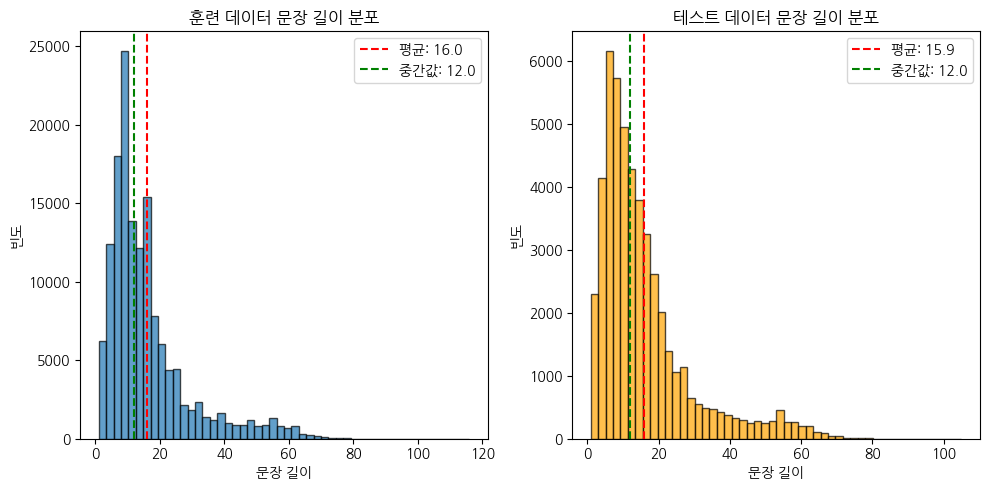

In [14]:
# 문장 길이 분포 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('문장 길이')
plt.ylabel('빈도')
plt.title('훈련 데이터 문장 길이 분포')
plt.axvline(np.mean(train_lengths), color='r', linestyle='--', label=f'평균: {np.mean(train_lengths):.1f}')
plt.axvline(np.median(train_lengths), color='g', linestyle='--', label=f'중간값: {np.median(train_lengths):.1f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(test_lengths, bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('문장 길이')
plt.ylabel('빈도')
plt.title('테스트 데이터 문장 길이 분포')
plt.axvline(np.mean(test_lengths), color='r', linestyle='--', label=f'평균: {np.mean(test_lengths):.1f}')
plt.axvline(np.median(test_lengths), color='g', linestyle='--', label=f'중간값: {np.median(test_lengths):.1f}')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# 문장 최대 길이 제한값 선정

# 전체 데이터 결합
total_data_text = list(X_train) + list(X_test)

# 텍스트 데이터 문장 길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차 계산
print(f'문장길이 평균: {np.mean(num_tokens):.2f}')
print(f'문장길이 최대: {np.max(num_tokens)}')
print(f'문장길이 표준편차: {np.std(num_tokens):.2f}')

# 95 백분위수로 maxlen 설정
maxlen = int(np.percentile(num_tokens, 95))

print(f'\n pad_sequences maxlen: {maxlen} (95 백분위수)')
print(f'\n 전체 문장의 {np.sum(num_tokens <= maxlen) / len(num_tokens) * 100:.1f}%가 maxlen 설정값 이내에 포함됩니다.')

문장길이 평균: 15.97
문장길이 최대: 116
문장길이 표준편차: 12.84

 pad_sequences maxlen: 47 (95 백분위수)

 전체 문장의 95.2%가 maxlen 설정값 이내에 포함됩니다.


In [16]:
# maxlen으로 시퀀스 자르기
X_train_cut = []
for seq in X_train:
    if len(seq) > maxlen:
        X_train_cut.append(seq[:maxlen])  # maxlen으로 자르기
    else:
        X_train_cut.append(seq)  # 그대로 유지

X_test_cut = []
for seq in X_test:
    if len(seq) > maxlen:
        X_test_cut.append(seq[:maxlen])
    else:
        X_test_cut.append(seq)

print(f"시퀀스 자르기 완료!")

시퀀스 자르기 완료!


In [17]:
# 리스트를 텐서로 변환
X_train_tensors = [torch.tensor(seq, dtype=torch.long) for seq in X_train_cut]
X_test_tensors = [torch.tensor(seq, dtype=torch.long) for seq in X_test_cut]

# torch pad_sequence로 패딩 추가
X_train_tensor = pad_sequence(X_train_tensors, batch_first=True, padding_value=0)
X_test_tensor = pad_sequence(X_test_tensors, batch_first=True, padding_value=0)

print(f"패딩 추가 완료!")

패딩 추가 완료!


In [18]:
# 레이블을 텐서로 변환
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

print(f"데이터 전처리 완료!")
print(f"  X_train shape: {X_train_tensor.shape}")
print(f"  X_test shape: {X_test_tensor.shape}")
print(f"  y_train shape: {y_train_tensor.shape}")
print(f"  y_test shape: {y_test_tensor.shape}")

데이터 전처리 완료!
  X_train shape: torch.Size([146179, 47])
  X_test shape: torch.Size([49155, 47])
  y_train shape: torch.Size([146179])
  y_test shape: torch.Size([49155])


## 4. 모델 구성

### RNN

In [19]:
class SentimentRNN(nn.Module):
    """기본 RNN 기반 감성분석 모델"""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.5):
        super(SentimentRNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, 
                         batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        
        rnn_out, hidden = self.rnn(embedded)
        # rnn_out: [batch_size, seq_len, hidden_dim]
        # hidden: [n_layers, batch_size, hidden_dim]
        
        # 마지막 레이어의 hidden state 사용
        hidden = hidden[-1]  # [batch_size, hidden_dim]
        
        x = self.dropout(hidden)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

### LSTM

In [20]:
class SentimentLSTM(nn.Module):
    """LSTM 기반 감성분석 모델"""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.5):
        super(SentimentLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, 
                           batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # hidden: [n_layers, batch_size, hidden_dim]
        
        # 마지막 레이어의 hidden state 사용
        hidden = hidden[-1]  # [batch_size, hidden_dim]
        
        x = self.dropout(hidden)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

### CNN

In [21]:
class SentimentCNN(nn.Module):
    """1D CNN 기반 감성분석 모델"""
    
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout=0.5):
        super(SentimentCNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # 다양한 크기의 필터 사용
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=n_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        embedded = embedded.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]
        
        # 각 필터 적용
        conved = [self.relu(conv(embedded)) for conv in self.convs]
        # conved[i]: [batch_size, n_filters, seq_len - filter_sizes[i] + 1]
        
        # Max pooling
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled[i]: [batch_size, n_filters]
        
        # Concatenate
        cat = torch.cat(pooled, dim=1)  # [batch_size, n_filters * len(filter_sizes)]
        cat = self.dropout(cat)
        
        x = self.fc1(cat)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

### Global Max Pooling

In [22]:
class SentimentGlobalMaxPool(nn.Module):
    """Global Max Pooling 기반 감성분석 모델"""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(SentimentGlobalMaxPool, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        embedded = embedded.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]
        
        # Global Max Pooling
        pooled = self.global_max_pool(embedded).squeeze(2)  # [batch_size, embedding_dim]
        
        x = self.dropout(pooled)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

## 5. 모델 훈련

In [23]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # 멀티 GPU 사용 시
    np.random.seed(seed)
    random.seed(seed)

RDN_SEED = 42

In [24]:
# 모델 학습 관련 하이퍼파라미터 설정

# 모델 아키텍처 하이퍼파라미터
EMBEDDING_DIM = 128      # 임베딩 벡터 차원
HIDDEN_DIM = 256         # RNN/LSTM hidden state 차원
N_LAYERS = 2             # RNN/LSTM 레이어 수
DROPOUT = 0.5            # 과적합 방지 차원에서 비교적 높은 dropout 비율 지정

# CNN 하이퍼파라미터
N_FILTERS = 100          # 필터 개수
FILTER_SIZES = [3, 4, 5] # 필터 크기 목록

# 훈련 하이퍼파라미터
BATCH_SIZE = 32          # 배치 크기
LEARNING_RATE = 0.001    # 학습률
EPOCHS = 15              # 에폭 수

# 스케줄러 하이퍼파라미터
SCHEDULER_FACTOR = 0.1   # 학습률 감소 비율
SCHEDULER_PATIENCE = 2   # 학습률 감소 대기 에포크

# 공통 파라미터
vocab_size = len(word_to_index)
output_dim = 1

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# TensorDataset 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor) # TensorDataset 객체 생성
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Validation set 분리 (훈련 데이터의 20%)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"  훈련 데이터: {len(train_dataset):,}개")
print(f"  검증 데이터: {len(val_dataset):,}개")
print(f"  테스트 데이터: {len(test_dataset):,}개")

  훈련 데이터: 116,943개
  검증 데이터: 29,236개
  테스트 데이터: 49,155개


In [26]:
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"  배치 크기: {BATCH_SIZE}")
print(f"  훈련 배치 수: {len(train_loader)}")
print(f"  검증 배치 수: {len(val_loader)}")
print(f"  테스트 배치 수: {len(test_loader)}")

  배치 크기: 32
  훈련 배치 수: 3655
  검증 배치 수: 914
  테스트 배치 수: 1537


In [27]:
def create_model(model_name, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers, dropout, n_filters, filter_sizes):
    """모델 이름에 따라 적절한 모델 생성"""
    
    if model_name == 'RNN':
        return SentimentRNN(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            n_layers=n_layers,
            dropout=dropout
        )
    elif model_name == 'LSTM':
        return SentimentLSTM(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            n_layers=n_layers,
            dropout=dropout
        )
    elif model_name == 'CNN':
        return SentimentCNN(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            n_filters=n_filters,
            filter_sizes=filter_sizes,
            output_dim=output_dim,
            dropout=dropout
        )
    elif model_name == 'GlobalMaxPool':
        return SentimentGlobalMaxPool(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=dropout
        )
    else:
        raise ValueError(f"Unknown model name: {model_name}")

In [28]:
# 파라미터 수 계산 함수
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [29]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """한 에포크 훈련"""
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        rounded_preds = torch.round(predictions)
        correct = (rounded_preds == labels).float()
        acc = correct.sum() / len(correct)
        epoch_acc += acc.item()
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [30]:
def evaluate(model, dataloader, criterion, device):
    """모델 평가"""
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            rounded_preds = torch.round(predictions)
            correct = (rounded_preds == labels).float()
            acc = correct.sum() / len(correct)
            epoch_acc += acc.item()
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [31]:
set_seed(RDN_SEED) # 재현성을 위한 random seed 고정

# 모든 모델 훈련
print("\n" + "=" * 80)
print("모델 훈련 시작")
print("=" * 80)

# 훈련할 모델 리스트
model_names = ['RNN', 'LSTM', 'CNN', 'GlobalMaxPool']

# 모든 모델의 결과를 저장할 딕셔너리
all_results = {}

for model_name in model_names:
    print("\n" + "=" * 80)
    print(f"[{model_name}] 모델 훈련 중...")
    print("=" * 80)
    
    # 모델 생성
    model = create_model(
        model_name=model_name,
        vocab_size=vocab_size,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=output_dim,
        n_layers=N_LAYERS,
        dropout=DROPOUT,
        n_filters=N_FILTERS,
        filter_sizes=FILTER_SIZES
    )
    model = model.to(device)
    
    print(f"\n{model_name} 모델 파라미터 수: {count_parameters(model):,}")
    
    # 손실 함수 및 옵티마이저 설정
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=SCHEDULER_FACTOR, 
        patience=SCHEDULER_PATIENCE
    )
    
    # 훈련
    best_val_loss = float('inf')
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(EPOCHS):
        # 훈련
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # 검증
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # 진행상황 출력 (3 에포크마다)
        if (epoch + 1) % 3 == 0 or epoch == 0:
            print(f"  Epoch [{epoch+1}/{EPOCHS}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        
        # 학습률 스케줄러 업데이트
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        # 학습률이 변경되면 출력
        if old_lr != new_lr:
            print(f"  Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")
        
        # 최고 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_model_{model_name}.pt')
    
    # 테스트 평가
    model.load_state_dict(torch.load(f'best_model_{model_name}.pt'))
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    print(f"\n[{model_name}] 훈련 완료")
    print(f"   최종 Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")
    
    # 결과 저장
    all_results[model_name] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'best_val_loss': best_val_loss,
        'num_params': count_parameters(model)
    }

print("\n" + "=" * 80)
print("모든 모델 훈련 완료")
print("=" * 80)


모델 훈련 시작

[RNN] 모델 훈련 중...

RNN 모델 파라미터 수: 1,543,425
  Epoch [1/15] - Train Loss: 0.6978, Train Acc: 50.08% | Val Loss: 0.7032, Val Acc: 49.01%
  Epoch [3/15] - Train Loss: 0.6968, Train Acc: 50.37% | Val Loss: 0.6933, Val Acc: 50.19%
  Epoch [6/15] - Train Loss: 0.6966, Train Acc: 50.36% | Val Loss: 0.6934, Val Acc: 49.98%
  Learning rate reduced: 0.001000 → 0.000100
  Epoch [9/15] - Train Loss: 0.6926, Train Acc: 51.70% | Val Loss: 0.6924, Val Acc: 51.76%
  Learning rate reduced: 0.000100 → 0.000010
  Epoch [12/15] - Train Loss: 0.6925, Train Acc: 51.76% | Val Loss: 0.6926, Val Acc: 51.38%
  Learning rate reduced: 0.000010 → 0.000001
  Epoch [15/15] - Train Loss: 0.6922, Train Acc: 51.79% | Val Loss: 0.6925, Val Acc: 51.67%

[RNN] 훈련 완료
   최종 Test Loss: 0.6917, Test Accuracy: 52.54%

[LSTM] 모델 훈련 중...

LSTM 모델 파라미터 수: 2,234,625
  Epoch [1/15] - Train Loss: 0.6923, Train Acc: 51.16% | Val Loss: 0.6908, Val Acc: 49.61%
  Epoch [3/15] - Train Loss: 0.6494, Train Acc: 57.28% | Val Loss:

In [32]:
print("\n" + "=" * 80)
print(" 모델 성능 비교")
print("=" * 80)

# 비교 표 생성
print(f"\n{'Model':<20} {'Parameters':>15} {'Best Val Loss':>15} {'Test Loss':>12} {'Test Acc':>12}")
print("-" * 80)

for model_name in model_names:
    result = all_results[model_name]
    print(f"{model_name:<20} {result['num_params']:>15,} "
          f"{result['best_val_loss']:>15.4f} "
          f"{result['test_loss']:>12.4f} "
          f"{result['test_acc']*100:>11.2f}%")


 모델 성능 비교

Model                     Parameters   Best Val Loss    Test Loss     Test Acc
--------------------------------------------------------------------------------
RNN                        1,543,425          0.6923       0.6917       52.54%
LSTM                       2,234,625          0.3390       0.3362       85.17%
CNN                        1,472,557          0.3341       0.3346       85.64%
GlobalMaxPool              1,313,281          0.3599       0.3602       84.63%


## 6. Loss, Accuracy 변화 추이 시각화

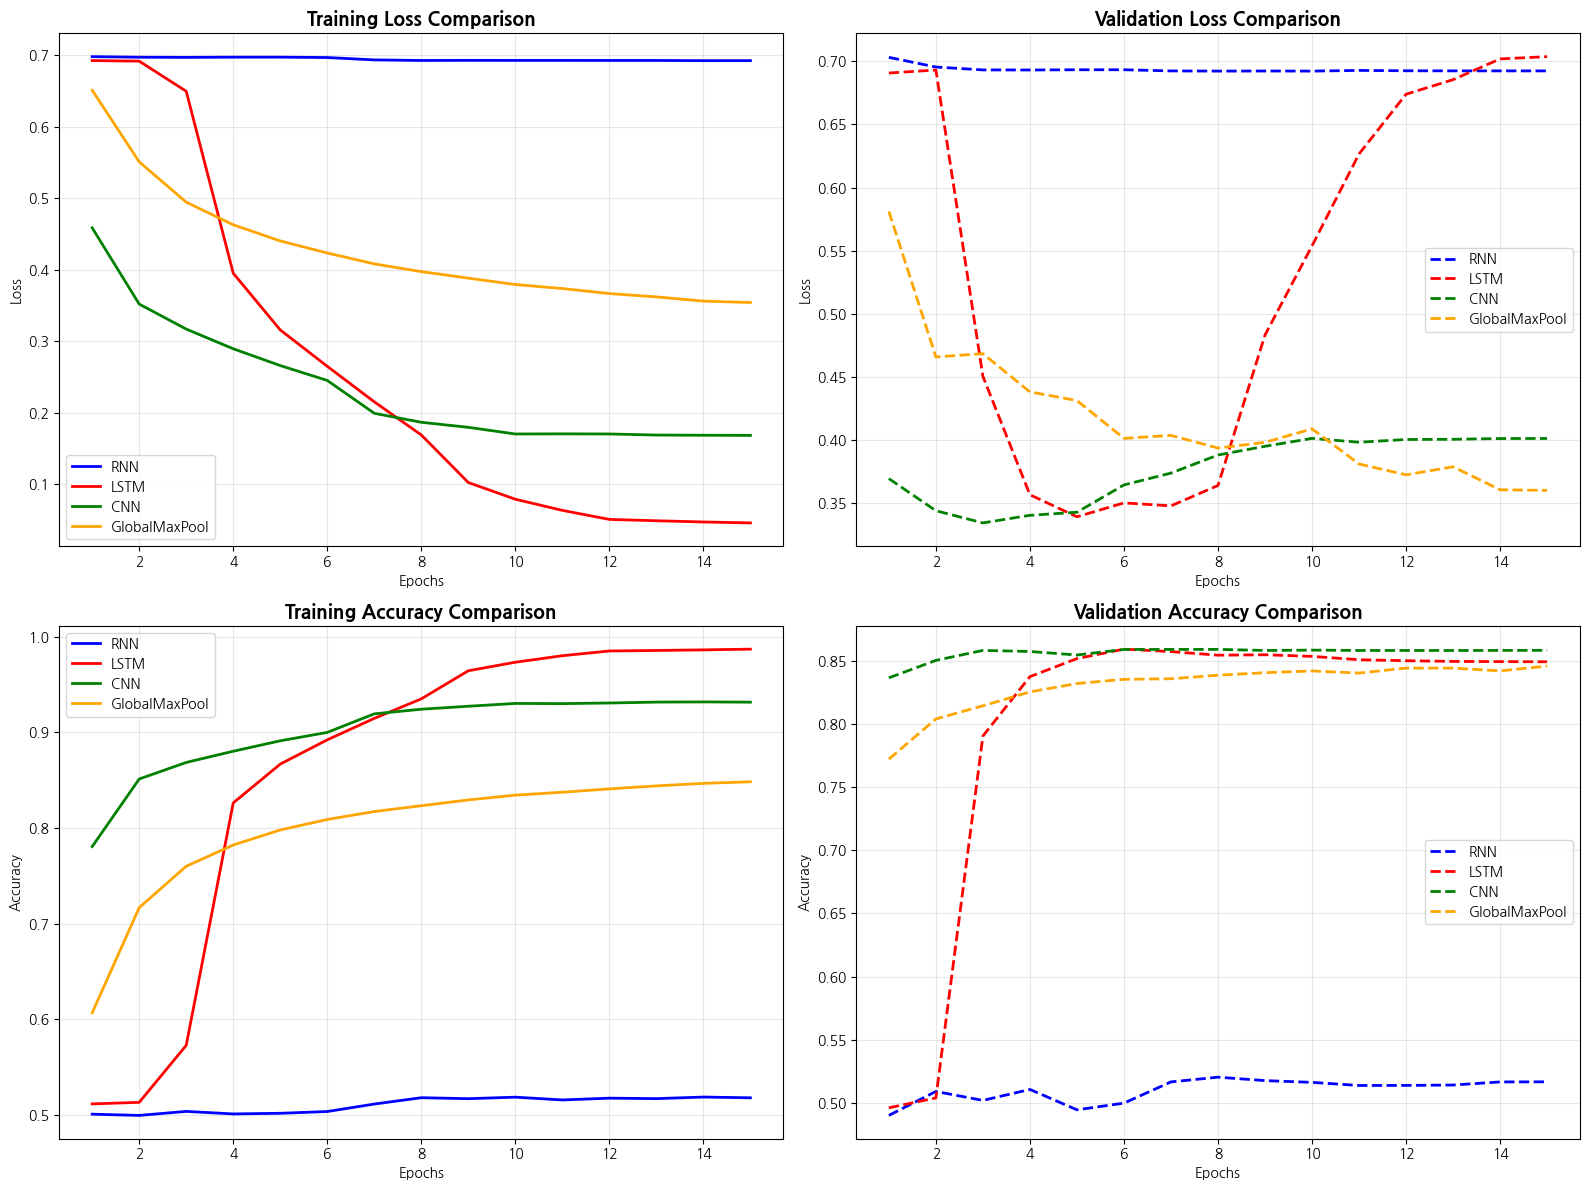

In [33]:
# 기본 모델별 Train/Val Loss & Accuracy 비교 시각화
epochs_range = range(1, EPOCHS + 1)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 색상 및 스타일 설정
colors = {'RNN': 'blue', 'LSTM': 'red', 'CNN': 'green', 'GlobalMaxPool': 'orange'}
styles = {'train': '-', 'val': '--'}

# Training Loss 비교
ax = axes[0, 0]
for model_name in model_names:
    result = all_results[model_name]
    ax.plot(epochs_range, result['train_losses'], 
            color=colors[model_name], linestyle=styles['train'], 
            label=f'{model_name}', linewidth=2)
ax.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Loss 비교
ax = axes[0, 1]
for model_name in model_names:
    result = all_results[model_name]
    ax.plot(epochs_range, result['val_losses'], 
            color=colors[model_name], linestyle=styles['val'], 
            label=f'{model_name}', linewidth=2)
ax.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Training Accuracy 비교
ax = axes[1, 0]
for model_name in model_names:
    result = all_results[model_name]
    ax.plot(epochs_range, result['train_accs'], 
            color=colors[model_name], linestyle=styles['train'], 
            label=f'{model_name}', linewidth=2)
ax.set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Accuracy 비교
ax = axes[1, 1]
for model_name in model_names:
    result = all_results[model_name]
    ax.plot(epochs_range, result['val_accs'], 
            color=colors[model_name], linestyle=styles['val'], 
            label=f'{model_name}', linewidth=2)
ax.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 학습된 임베딩 레이어 분석

In [34]:
# 상위권 성적을 낸 모델(LSTM) 로드
lstm_model_best = create_model(
    model_name='LSTM',
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=output_dim,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
    n_filters=N_FILTERS,
    filter_sizes=FILTER_SIZES
)
lstm_model_best.load_state_dict(torch.load('best_model_LSTM.pt'))
lstm_model_best = lstm_model_best.to(device)

# Embedding 가중치 추출
embedding_weights = lstm_model_best.embedding.weight.detach().cpu().numpy()

print(f"Embedding 가중치 정보:")
print(f"  Shape: {embedding_weights.shape}")
print(f"  (vocab_size: {embedding_weights.shape[0]:,}, embedding_dim: {embedding_weights.shape[1]})")

Embedding 가중치 정보:
  Shape: (10000, 128)
  (vocab_size: 10,000, embedding_dim: 128)


In [35]:
# 기본 벡터 확인
# 특정 단어들의 임베딩 벡터 확인
test_words = ['영화', '재미있', '지루하', '최고', '최악', '감동', '연기', '스토리']

print(f"특정 단어들의 임베딩 벡터:")
for word in test_words:
    if word in word_to_index:
        idx = word_to_index[word]
        vector = embedding_weights[idx]
        print(f"\n  '{word}' (index: {idx})")
        print(f"    벡터 (처음 5개): {vector[:5]}")
        print(f"    벡터 크기(norm): {np.linalg.norm(vector):.4f}")
    else:
        print(f"\n  '{word}' - 사전에 없는 단어")

특정 단어들의 임베딩 벡터:

  '영화' (index: 5)
    벡터 (처음 5개): [-0.11789037 -1.2109557  -1.0967762  -0.71168613  1.2442755 ]
    벡터 크기(norm): 12.3780

  '재미있' (index: 98)
    벡터 (처음 5개): [-0.2548923   1.212788    1.9326288  -1.4147077   0.80917305]
    벡터 크기(norm): 12.8914

  '지루하' - 사전에 없는 단어

  '최고' (index: 56)
    벡터 (처음 5개): [-1.0125456  1.4476186  0.6574121  1.1617202  1.0183003]
    벡터 크기(norm): 12.8095

  '최악' (index: 159)
    벡터 (처음 5개): [-0.15388837  0.67216176  1.0102     -0.97048503 -1.3161975 ]
    벡터 크기(norm): 14.7386

  '감동' (index: 80)
    벡터 (처음 5개): [-0.53935117 -0.03904336 -1.570753    1.1781532   0.17966092]
    벡터 크기(norm): 12.4308

  '연기' (index: 53)
    벡터 (처음 5개): [ 2.1969974  -0.18669209 -0.48043436 -0.5451162   0.11463883]
    벡터 크기(norm): 13.2074

  '스토리' (index: 67)
    벡터 (처음 5개): [-1.3034406  -1.4897544  -1.842657   -0.68511766 -0.39573735]
    벡터 크기(norm): 11.6767


In [36]:
# 코사인 유사도 분석 
def get_similar_words_cosine(word, word_to_index, embedding_weights, top_n=10):
    """코사인 유사도로 유사한 단어 찾기"""
    if word not in word_to_index:
        return None
    
    word_idx = word_to_index[word]
    word_vector = embedding_weights[word_idx].reshape(1, -1)
    
    # 전체 단어와의 코사인 유사도 계산
    similarities = cosine_similarity(word_vector, embedding_weights)[0]
    
    # 자기 자신 제외하고 상위 N개 추출
    similar_indices = np.argsort(similarities)[::-1][1:top_n+1]
    
    results = []
    for idx in similar_indices:
        word_similar = index_to_word[idx]
        similarity = similarities[idx]
        results.append((word_similar, similarity))
    
    return results

# 감성 관련 단어들의 유사 단어 찾기
query_words = ['재미있', '지루하', '최고', '최악', '감동', '웃음', '슬프']

for word in query_words:
    if word in word_to_index:
        print(f"\n'{word}'와 유사한 단어들 (코사인 유사도):")
        similar = get_similar_words_cosine(word, word_to_index, embedding_weights, top_n=5)
        if similar:
            for similar_word, sim_score in similar:
                print(f"  {similar_word}: {sim_score:.4f}")
    else:
        print(f"\n'{word}' - 사전에 없는 단어")


'재미있'와 유사한 단어들 (코사인 유사도):
  단면: 0.3364
  남긴다: 0.3209
  의혹: 0.3185
  뜨거운: 0.3128
  주식: 0.3082

'지루하' - 사전에 없는 단어

'최고'와 유사한 단어들 (코사인 유사도):
  즐겁: 0.3165
  한몫: 0.3095
  창의력: 0.2983
  훌쩍: 0.2950
  차마: 0.2903

'최악'와 유사한 단어들 (코사인 유사도):
  퉤: 0.3867
  졸작: 0.3676
  관계자: 0.3504
  식상: 0.3500
  그닥: 0.3469

'감동'와 유사한 단어들 (코사인 유사도):
  이창동: 0.3318
  패션: 0.3268
  정우: 0.3200
  윌리엄스: 0.3130
  용어: 0.3100

'웃음'와 유사한 단어들 (코사인 유사도):
  망침: 0.3373
  급조: 0.3041
  눈감: 0.2975
  혁: 0.2943
  ㅂ: 0.2920

'슬프'와 유사한 단어들 (코사인 유사도):
  드러낸: 0.3645
  짐캐리: 0.3180
  개지: 0.3035
  머니: 0.2959
  런던: 0.2928


  t-SNE 실행 중... (26개 단어)


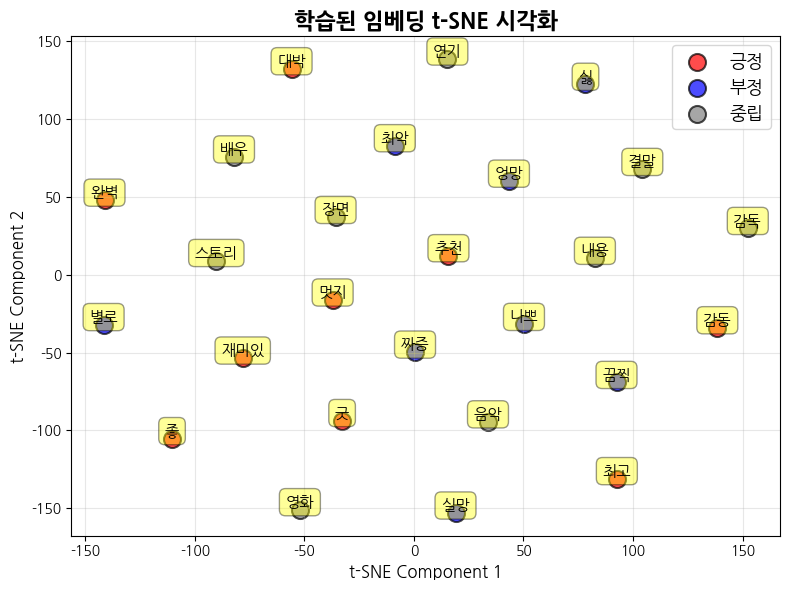

✅ t-SNE 시각화 완료!
   긍정 단어: 9개
   부정 단어: 8개
   중립 단어: 9개


In [37]:
# t-SNE(t-distributed Stochastic Neighbor Embedding)를 활용한 Embedding 시각화

# 시각화할 단어들 선택
visualization_words = {
    '긍정': ['좋', '재미있', '최고', '훌륭하', '감동', '멋지', '완벽', '추천', '대박', '굿'],
    '부정': ['나쁘', '지루하', '최악', '엉망', '실망', '별로', '짜증', '비추천', '끔찍', '싫'],
    '중립': ['영화', '스토리', '연기', '감독', '배우', '장면', '음악', '결말', '내용']
}

# 사전에 있는 단어만 필터링
plot_words = []
plot_labels = []
plot_colors = []
plot_embeddings = []

color_map = {'긍정': 'red', '부정': 'blue', '중립': 'gray'}

for category, words in visualization_words.items():
    for word in words:
        if word in word_to_index:
            idx = word_to_index[word]
            plot_words.append(word)
            plot_labels.append(category)
            plot_colors.append(color_map[category])
            plot_embeddings.append(embedding_weights[idx])

if len(plot_embeddings) > 1:
    plot_embeddings = np.array(plot_embeddings)
    
    # t-SNE로 2D 축소
    print(f"  t-SNE 실행 중... ({len(plot_embeddings)}개 단어)")
    tsne = TSNE(
        n_components=2, 
        random_state=42, 
        perplexity=min(30, len(plot_embeddings)-1),
        max_iter=1000
    )
    embeddings_2d = tsne.fit_transform(plot_embeddings)
    
    # 시각화
    plt.figure(figsize=(8, 6))
    
    # 카테고리별로 scatter
    for category, color in color_map.items():
        mask = [label == category for label in plot_labels]
        if any(mask):
            indices = [i for i, m in enumerate(mask) if m]
            plt.scatter(
                embeddings_2d[indices, 0], 
                embeddings_2d[indices, 1], 
                c=color, 
                label=category, 
                s=150,  # 점 크기
                alpha=0.7, 
                edgecolors='black',
                linewidths=1.5
            )
    
    # 단어 레이블 추가
    for i, word in enumerate(plot_words):
        plt.annotate(
            word, 
            (embeddings_2d[i, 0], embeddings_2d[i, 1]),
            fontsize=11, 
            ha='center', 
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.4, edgecolor='black')
        )
    
    plt.title('학습된 임베딩 t-SNE 시각화', fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.legend(fontsize=13, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("✅ t-SNE 시각화 완료!")
    print(f"   긍정 단어: {sum([1 for l in plot_labels if l == '긍정'])}개")
    print(f"   부정 단어: {sum([1 for l in plot_labels if l == '부정'])}개")
    print(f"   중립 단어: {sum([1 for l in plot_labels if l == '중립'])}개")
else:
    print("시각화할 단어가 충분하지 않습니다.")

t-SNE를 통해 자체 학습된 임베딩 공간을 시각화한 결과, 감성 분류에 핵심적인 단어들이 일부 군집을 형성하고 있음을 확인했다. 하지만 단어 간 거리가 충분히 가깝지 않고, 의미적 유사성보다는 데이터 내 동시 출현 빈도에 따라 단어들이 배치되는(예: '감동'과 '감독') 한계를 보였다.

## 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [38]:
# 한국어 사전학습 Word2Vec 로드

# 주의! load_word2vec_format() 이 아닌 Word2Vec.load() 사용
pretrained_model = Word2Vec.load(DATA_DIR+'/word2vec_ko.model')
pretrained_wv = pretrained_model.wv

print(f"  Vocab size: {len(pretrained_wv):,}")
print(f"  Vector size: {pretrained_wv.vector_size}")

# 샘플 단어 확인
sample_words = ['영화', '재미있다', '좋다', '나쁘다']
print(f"사전학습 Word2Vec 샘플:")
for word in sample_words:
    if word in pretrained_wv:
        print(f"\n  '{word}':")
        print(f"    벡터 크기: {pretrained_wv[word].shape}")
        try:
            similar = pretrained_wv.most_similar(word, topn=5)
            print(f"    유사 단어: {[w for w, _ in similar]}")
        except:
            print(f"    유사도 계산 불가")

  Vocab size: 302,960
  Vector size: 100
사전학습 Word2Vec 샘플:

  '영화':
    벡터 크기: (100,)
    유사 단어: ['드라마', '뮤지컬', '코미디', '다큐멘터리', '헐리우드']


In [39]:
# 사전학습된 임베딩 Matrix 구성
embedding_dim_pretrained = pretrained_wv.vector_size

# 랜덤 초기화 (매칭되지 않는 단어용)
embedding_matrix = np.random.randn(vocab_size, embedding_dim_pretrained).astype(np.float32) * 0.01

# 특수 토큰은 0으로 초기화
embedding_matrix[0] = np.zeros(embedding_dim_pretrained)  # <PAD>
embedding_matrix[1] = np.random.randn(embedding_dim_pretrained) * 0.01  # <BOS>
embedding_matrix[2] = np.random.randn(embedding_dim_pretrained) * 0.01  # <UNK>
embedding_matrix[3] = np.random.randn(embedding_dim_pretrained) * 0.01  # <UNUSED>

# 사전학습된 벡터로 채우기
matched = 0
for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in pretrained_wv:
        embedding_matrix[i] = pretrained_wv[word]
        matched += 1

print(f"  전체 단어: {vocab_size:,}개")
print(f"  매칭된 단어: {matched:,}개 ({matched/(vocab_size-4)*100:.1f}%)")
print(f"  매칭 안 된 단어: {vocab_size - 4 - matched:,}개")
print(f"  Embedding 차원: {embedding_dim_pretrained}")

  전체 단어: 10,000개
  매칭된 단어: 9,457개 (94.6%)
  매칭 안 된 단어: 539개
  Embedding 차원: 100


In [40]:
class SentimentRNNPretrained(nn.Module):
    """사전학습된 Embedding을 사용하는 RNN 모델"""
    
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, 
                 output_dim, n_layers=2, dropout=0.5, freeze_embedding=False):
        super(SentimentRNNPretrained, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = not freeze_embedding
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers,
                         batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, hidden = self.rnn(embedded)
        hidden = hidden[-1]
        
        x = self.dropout(hidden)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

In [41]:
class SentimentLSTMPretrained(nn.Module):
    """사전학습된 Embedding을 사용하는 LSTM 모델"""
    
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, 
                 output_dim, n_layers=2, dropout=0.5, freeze_embedding=False):
        super(SentimentLSTMPretrained, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = not freeze_embedding
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = hidden[-1]
        
        x = self.dropout(hidden)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

In [42]:
class SentimentCNNPretrained(nn.Module):
    """사전학습된 Embedding을 사용하는 CNN 모델"""
    
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, n_filters, 
                 filter_sizes, output_dim, dropout=0.5, freeze_embedding=False):
        super(SentimentCNNPretrained, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = not freeze_embedding
        
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=n_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        
        conved = [self.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        
        x = self.fc1(cat)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

In [43]:
class SentimentGlobalMaxPoolPretrained(nn.Module):
    """사전학습된 Embedding을 사용하는 Global Max Pooling 모델"""
    
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, 
                 output_dim, dropout=0.5, freeze_embedding=False):
        super(SentimentGlobalMaxPoolPretrained, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = not freeze_embedding
        
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        
        pooled = self.global_max_pool(embedded).squeeze(2)
        
        x = self.dropout(pooled)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

In [44]:
# 사전학습 모델 생성 함수
def create_pretrained_model(model_name, vocab_size, embedding_dim, embedding_matrix, 
                            hidden_dim, output_dim, n_layers, dropout, 
                            n_filters, filter_sizes, freeze_embedding=False):
    """사전학습 임베딩을 사용하는 모델 생성"""
    
    if model_name == 'RNN':
        return SentimentRNNPretrained(
            vocab_size, embedding_dim, embedding_matrix, hidden_dim, 
            output_dim, n_layers, dropout, freeze_embedding
        )
    elif model_name == 'LSTM':
        return SentimentLSTMPretrained(
            vocab_size, embedding_dim, embedding_matrix, hidden_dim, 
            output_dim, n_layers, dropout, freeze_embedding
        )
    elif model_name == 'CNN':
        return SentimentCNNPretrained(
            vocab_size, embedding_dim, embedding_matrix, n_filters, 
            filter_sizes, output_dim, dropout, freeze_embedding
        )
    elif model_name == 'GlobalMaxPool':
        return SentimentGlobalMaxPoolPretrained(
            vocab_size, embedding_dim, embedding_matrix, hidden_dim, 
            output_dim, dropout, freeze_embedding
        )
    else:
        raise ValueError(f"Unknown model name: {model_name}")

In [46]:
set_seed(RDN_SEED) # 재현성을 위한 random seed 고정

# 모든 모델 훈련
print("\n" + "=" * 80)
print("모델 훈련 시작")
print("=" * 80)

# 사전학습 모델 결과 저장
pretrained_results = {}

for model_name in model_names:
    print("\n" + "=" * 80)
    print(f"[사전학습 {model_name}] 모델 훈련 중...")
    print("=" * 80)
    
    # 모델 생성
    model_pretrained = create_pretrained_model(
        model_name=model_name,
        vocab_size=vocab_size,
        embedding_dim=embedding_dim_pretrained,
        embedding_matrix=embedding_matrix,
        hidden_dim=HIDDEN_DIM,
        output_dim=output_dim,
        n_layers=N_LAYERS,
        dropout=DROPOUT,
        n_filters=N_FILTERS,
        filter_sizes=FILTER_SIZES,
        freeze_embedding=False  # Fine-tuning
    )
    model_pretrained = model_pretrained.to(device)
    
    print(f"  Embedding 레이어: Fine-tuning 모드")
    print(f"  사전학습 {model_name} 파라미터 수: {count_parameters(model_pretrained):,}")
    
    # 손실 함수 및 옵티마이저
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model_pretrained.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE
    )
    
    # 훈련
    best_val_loss = float('inf')
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(EPOCHS):
        # 훈련
        train_loss, train_acc = train_epoch(
            model_pretrained, train_loader, criterion, optimizer, device
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # 검증
        val_loss, val_acc = evaluate(model_pretrained, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # 진행상황 출력
        if (epoch + 1) % 3 == 0 or epoch == 0: # 3 에폭마다
            print(f"  Epoch [{epoch+1}/{EPOCHS}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        
        # 학습률 스케줄러
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print(f"  Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")
        
        # 최고 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model_pretrained.state_dict(), f'best_model_{model_name}_pretrained.pt')
    
    # 테스트 평가
    model_pretrained.load_state_dict(torch.load(f'best_model_{model_name}_pretrained.pt'))
    test_loss, test_acc = evaluate(model_pretrained, test_loader, criterion, device)
    
    print(f"\n [사전학습 {model_name}] 훈련 완료")
    print(f"   Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")
    
    # 결과 저장
    pretrained_results[model_name] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'best_val_loss': best_val_loss,
        'num_params': count_parameters(model_pretrained)
    }

print("\n" + "=" * 80)
print("모든 모델 훈련 완료")
print("=" * 80)


모델 훈련 시작

[사전학습 RNN] 모델 훈련 중...
  Embedding 레이어: Fine-tuning 모드
  사전학습 RNN 파라미터 수: 1,256,257
  Epoch [1/15] - Train Loss: 0.6976, Train Acc: 49.81% | Val Loss: 0.6933, Val Acc: 50.23%
  Epoch [3/15] - Train Loss: 0.6949, Train Acc: 49.98% | Val Loss: 0.6987, Val Acc: 50.45%
  Learning rate reduced: 0.001000 → 0.000100
  Epoch [6/15] - Train Loss: 0.6934, Train Acc: 50.04% | Val Loss: 0.6931, Val Acc: 50.44%
  Epoch [9/15] - Train Loss: 0.6933, Train Acc: 50.09% | Val Loss: 0.6932, Val Acc: 49.60%
  Learning rate reduced: 0.000100 → 0.000010
  Epoch [12/15] - Train Loss: 0.6932, Train Acc: 50.11% | Val Loss: 0.6931, Val Acc: 50.39%
  Learning rate reduced: 0.000010 → 0.000001
  Epoch [15/15] - Train Loss: 0.6932, Train Acc: 50.27% | Val Loss: 0.6931, Val Acc: 50.39%
  Learning rate reduced: 0.000001 → 0.000000

 [사전학습 RNN] 훈련 완료
   Test Loss: 0.6932, Test Accuracy: 49.72%

[사전학습 LSTM] 모델 훈련 중...
  Embedding 레이어: Fine-tuning 모드
  사전학습 LSTM 파라미터 수: 1,925,953
  Epoch [1/15] - Train Loss: 

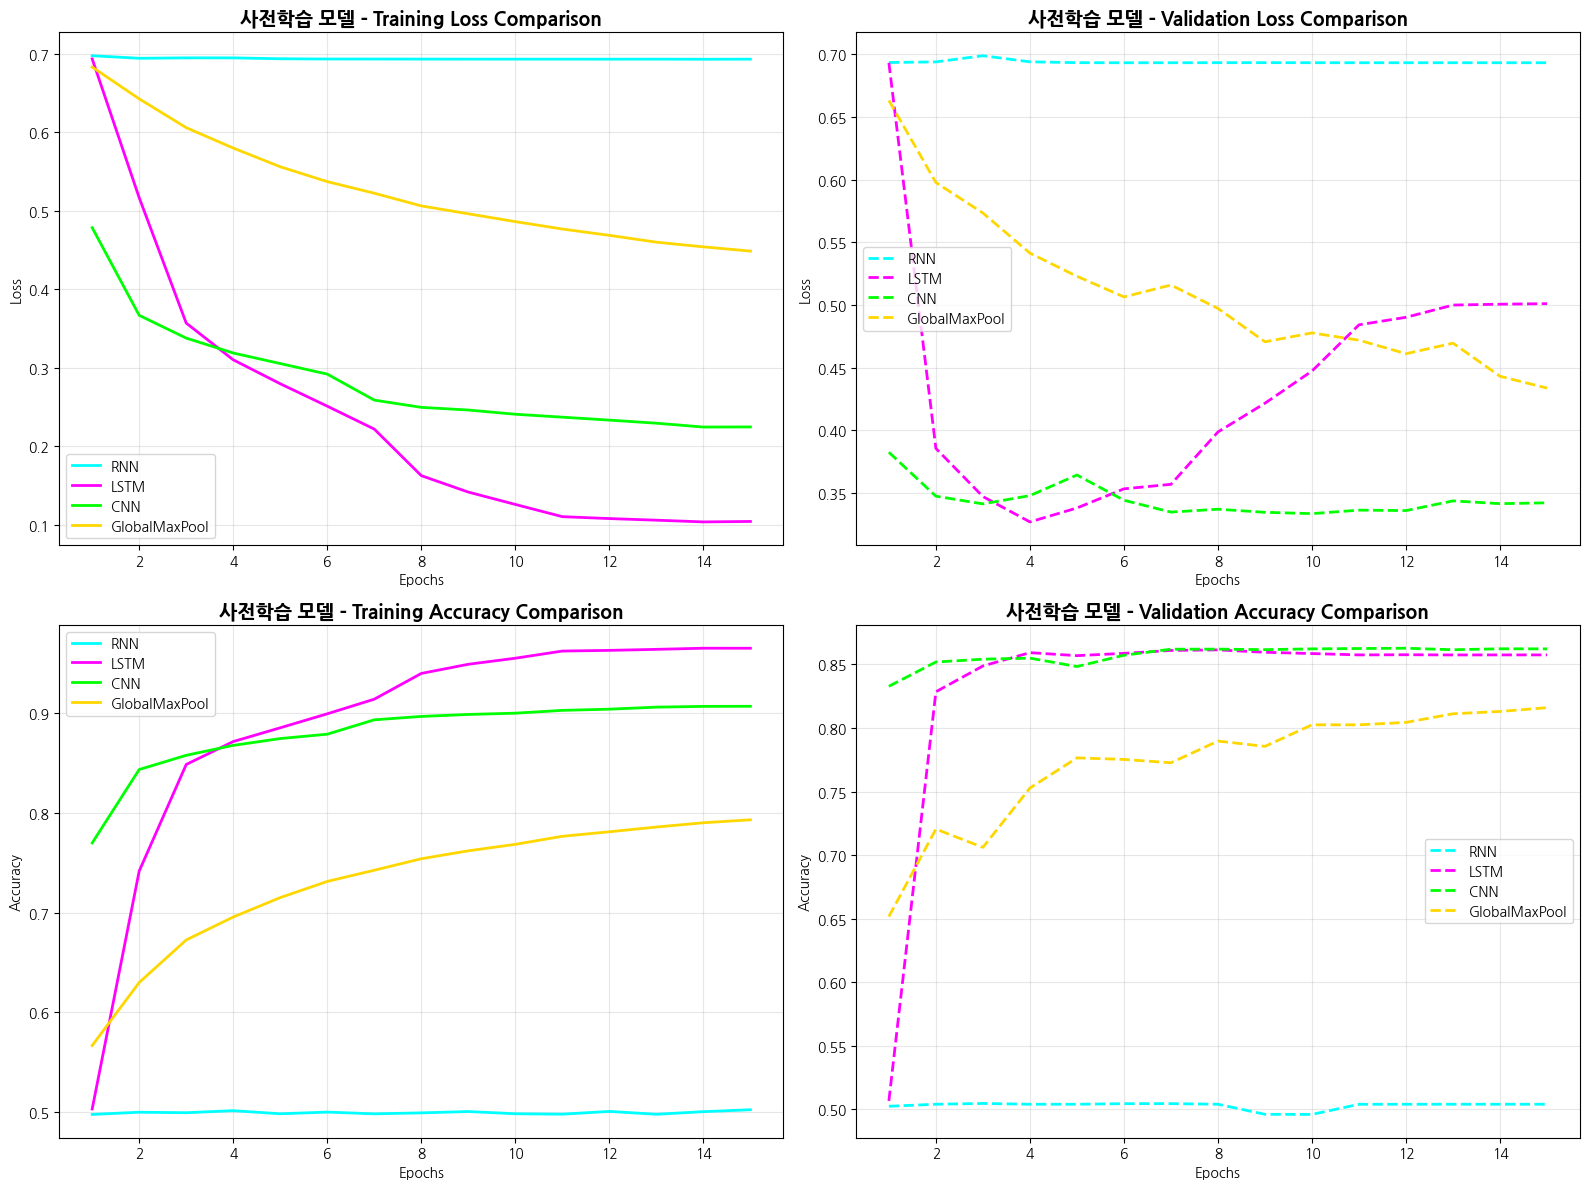

In [47]:
# 사전학습 모델별 Train/Val Loss & Accuracy 비교 시각화

epochs_range = range(1, EPOCHS + 1)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 색상 및 스타일 설정
colors = {'RNN': 'cyan', 'LSTM': 'magenta', 'CNN': 'lime', 'GlobalMaxPool': 'gold'}
styles = {'train': '-', 'val': '--'}

# Training Loss 비교
ax = axes[0, 0]
for model_name in model_names:
    result = pretrained_results[model_name]
    ax.plot(epochs_range, result['train_losses'], 
            color=colors[model_name], linestyle=styles['train'], 
            label=f'{model_name}', linewidth=2)
ax.set_title('사전학습 모델 - Training Loss Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Loss 비교
ax = axes[0, 1]
for model_name in model_names:
    result = pretrained_results[model_name]
    ax.plot(epochs_range, result['val_losses'], 
            color=colors[model_name], linestyle=styles['val'], 
            label=f'{model_name}', linewidth=2)
ax.set_title('사전학습 모델 - Validation Loss Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Training Accuracy 비교
ax = axes[1, 0]
for model_name in model_names:
    result = pretrained_results[model_name]
    ax.plot(epochs_range, result['train_accs'], 
            color=colors[model_name], linestyle=styles['train'], 
            label=f'{model_name}', linewidth=2)
ax.set_title('사전학습 모델 - Training Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Accuracy 비교
ax = axes[1, 1]
for model_name in model_names:
    result = pretrained_results[model_name]
    ax.plot(epochs_range, result['val_accs'], 
            color=colors[model_name], linestyle=styles['val'], 
            label=f'{model_name}', linewidth=2)
ax.set_title('사전학습 모델 - Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 기본 모델 vs 사전학습 모델 성능 비교
print(f"\n{'Model':<20} {'기본 Acc':>12} {'사전학습 Acc':>15} {'개선도':>12} {'상태':>10}")
print("-" * 80)

for model_name in model_names:
    basic_acc = all_results[model_name]['test_acc'] * 100
    pretrained_acc = pretrained_results[model_name]['test_acc'] * 100
    improvement = pretrained_acc - basic_acc
    
    # 상태 이모지
    if improvement > 0.5:
        status = "향상"
    elif improvement > 0:
        status = "미세향상"
    else:
        status = "감소"
    
    print(f"{model_name:<20} {basic_acc:>11.2f}% {pretrained_acc:>14.2f}% "
          f"{improvement:>11.2f}%p {status:>10}")

# 평균 개선도 계산
avg_improvement = np.mean([
    (pretrained_results[name]['test_acc'] - all_results[name]['test_acc']) * 100
    for name in model_names
])

print(f"\n평균 성능 개선: {avg_improvement:+.2f}%p")

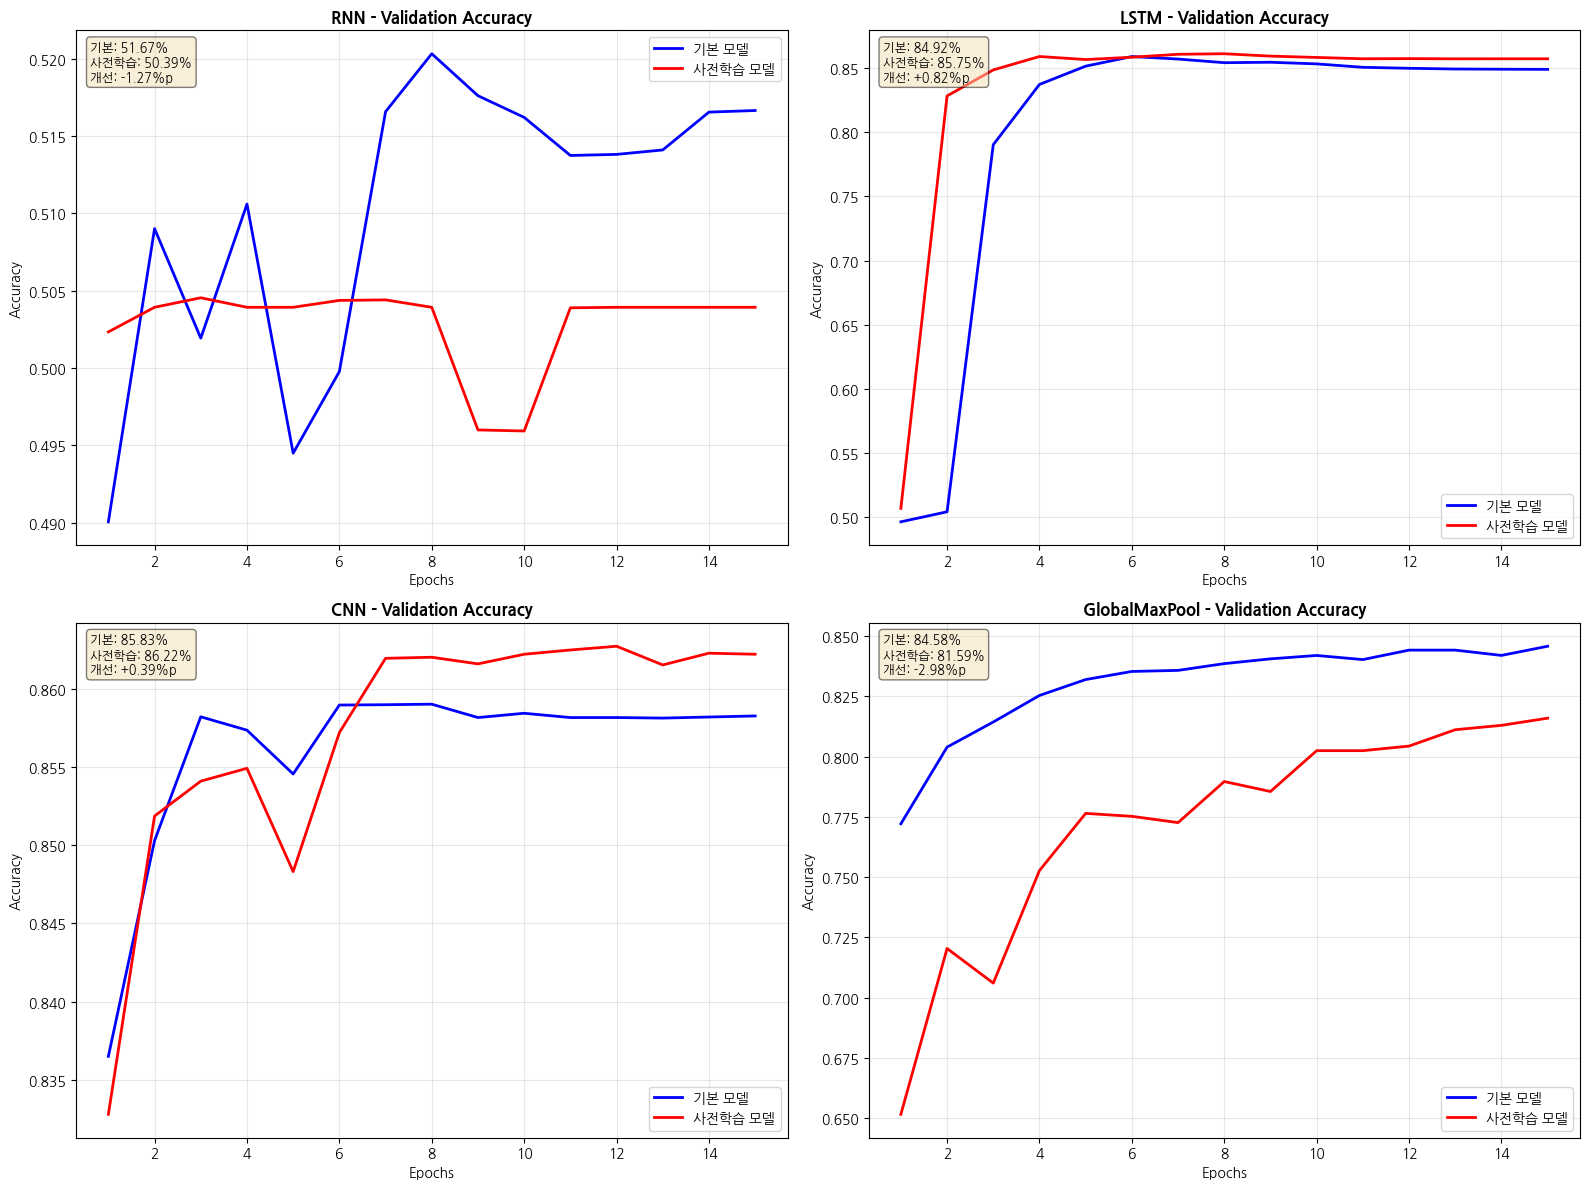

In [48]:
# 기본 vs. 사전 학습 모델별 train/val loss, accuracy 비교
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs_range_final = range(1, EPOCHS + 1)

for idx, model_name in enumerate(model_names):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # 기본 모델
    basic_result = all_results[model_name]
    ax.plot(epochs_range_final, basic_result['val_accs'], 
            'b-', label='기본 모델', linewidth=2)
    
    # 사전학습 모델
    pretrained_result = pretrained_results[model_name]
    ax.plot(epochs_range_final, pretrained_result['val_accs'], 
            'r-', label='사전학습 모델', linewidth=2)
    
    ax.set_title(f'{model_name} - Validation Accuracy', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 최종 정확도 표시
    final_basic = basic_result['val_accs'][-1] * 100
    final_pretrained = pretrained_result['val_accs'][-1] * 100
    improvement = final_pretrained - final_basic
    
    ax.text(0.02, 0.98, f'기본: {final_basic:.2f}%\n사전학습: {final_pretrained:.2f}%\n개선: {improvement:+.2f}%p',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [50]:
# 최종 결과 요약 및 분석
for model_name in model_names:
    basic = all_results[model_name]
    pretrained = pretrained_results[model_name]
    
    print(f"\n[{model_name}]")
    print(f"  기본 모델:")
    print(f"    - Test Acc: {basic['test_acc']*100:.2f}%")
    print(f"    - Test Loss: {basic['test_loss']:.4f}")
    
    print(f"  사전학습 모델:")
    print(f"    - Test Acc: {pretrained['test_acc']*100:.2f}%")
    print(f"    - Test Loss: {pretrained['test_loss']:.4f}")
    
    acc_diff = (pretrained['test_acc'] - basic['test_acc']) * 100
    loss_diff = basic['test_loss'] - pretrained['test_loss']
    
    print(f"  성능 변화:")
    print(f"    - Accuracy: {acc_diff:+.2f}%p")
    print(f"    - Loss: {loss_diff:+.4f}")

# 가장 개선된 모델 찾기
improvements = {
    name: (pretrained_results[name]['test_acc'] - all_results[name]['test_acc']) * 100
    for name in model_names
}

best_improved = max(improvements.keys(), key=lambda k: improvements[k])
worst_improved = min(improvements.keys(), key=lambda k: improvements[k])

print(f"\n 가장 많이 개선된 모델: {best_improved} ({improvements[best_improved]:+.2f}%p)")
print(f" 가장 적게 개선된 모델: {worst_improved} ({improvements[worst_improved]:+.2f}%p)")

# 결과 저장
all_results_combined = {
    'basic': all_results,
    'pretrained': pretrained_results
}

with open('all_models_comparison_with_pretrained.pkl', 'wb') as f:
    pickle.dump(all_results_combined, f)

print("\n 모든 결과가 'all_models_comparison_with_pretrained.pkl'에 저장되었습니다!")


[RNN]
  기본 모델:
    - Test Acc: 52.54%
    - Test Loss: 0.6917
  사전학습 모델:
    - Test Acc: 49.72%
    - Test Loss: 0.6932
  성능 변화:
    - Accuracy: -2.82%p
    - Loss: -0.0015

[LSTM]
  기본 모델:
    - Test Acc: 85.17%
    - Test Loss: 0.3362
  사전학습 모델:
    - Test Acc: 85.60%
    - Test Loss: 0.3278
  성능 변화:
    - Accuracy: +0.43%p
    - Loss: +0.0084

[CNN]
  기본 모델:
    - Test Acc: 85.64%
    - Test Loss: 0.3346
  사전학습 모델:
    - Test Acc: 86.16%
    - Test Loss: 0.3306
  성능 변화:
    - Accuracy: +0.52%p
    - Loss: +0.0041

[GlobalMaxPool]
  기본 모델:
    - Test Acc: 84.63%
    - Test Loss: 0.3602
  사전학습 모델:
    - Test Acc: 81.92%
    - Test Loss: 0.4322
  성능 변화:
    - Accuracy: -2.71%p
    - Loss: -0.0720

 가장 많이 개선된 모델: CNN (+0.52%p)
 가장 적게 개선된 모델: RNN (-2.82%p)

 모든 결과가 'all_models_comparison_with_pretrained.pkl'에 저장되었습니다!


In [55]:
# 보너스: 자체학습 임베딩과 사전학습 임베딩 비교
from gensim.models import KeyedVectors

# 비교 분석 함수 정의
def compare_embeddings_final(word, self_model, pretrained_model):
    print(f"단어 '{word}' 비교 분석")
    print("-" * 40)
    
    # 자체 학습 (LSTM Embedding Layer)
    print(f"{' [자체 학습 임베딩] ':=^30}")
    try:
        for w, s in self_model.most_similar(word, topn=5):
            print(f"{w:<10} | {s:.4f}")
    except KeyError:
        print("단어가 자체 사전에 없습니다.")
        
    print()
    
    # 사전 학습 (KO Word2Vec)
    print(f"{' [사전 학습 임베딩] ':=^30}")
    try:
        for w, s in pretrained_model.most_similar(word, topn=5):
            print(f"{w:<10} | {s:.4f}")
    except KeyError:
        print("단어가 사전 학습 모델에 없습니다.")
    print("-" * 40 + "\n")

# 자체 학습 임베딩(LSTM 가중치)을 gensim KeyedVectors 객체로 변환
# index_to_word는 토큰화 과정에서 생성된 인덱스-단어 사전 리스트
words = [index_to_word[i] for i in range(len(index_to_word))]
my_v2w = KeyedVectors(vector_size=EMBEDDING_DIM)
my_v2w.add_vectors(words, embedding_weights)

# 주요 단어 비교 실행
compare_words = ['재미', '최고', '감동', '별로', '지루']
for w in compare_words:
    compare_embeddings_final(w, my_v2w, pretrained_wv)

단어 '재미' 비교 분석
----------------------------------------
======== [자체 학습 임베딩] =========
死          | 0.3221
데이         | 0.3147
멀미         | 0.3134
무죄         | 0.3093
that       | 0.3009

======== [사전 학습 임베딩] =========
묘미         | 0.6163
취미         | 0.6035
흥미         | 0.5940
유머         | 0.5889
보람         | 0.5690
----------------------------------------

단어 '최고' 비교 분석
----------------------------------------
======== [자체 학습 임베딩] =========
즐겁         | 0.3165
한몫         | 0.3095
창의력        | 0.2983
훌쩍         | 0.2950
차마         | 0.2903

======== [사전 학습 임베딩] =========
역대         | 0.6544
최다         | 0.6140
최악         | 0.6104
최대         | 0.6002
최저         | 0.5937
----------------------------------------

단어 '감동' 비교 분석
----------------------------------------
======== [자체 학습 임베딩] =========
이창동        | 0.3318
패션         | 0.3268
정우         | 0.3200
윌리엄스       | 0.3130
용어         | 0.3100

======== [사전 학습 임베딩] =========
감격         | 0.8046
감탄         | 0.7327
매혹         | 0.7267
매력

## 결론

- 가장 우수한 성능을 보인 CNN + Word2Vec 조합은 테스트 데이터셋에서 약 **86.16\%**의 정확도를 달성하며 프로젝트 목표치를 성공적으로 충족했다.

   - CNN은 문장 내 지역적인 특징(n-gram 패턴)을 효과적으로 추출하는데, 여기에 사전 학습된 벡터의 풍부한 의미 정보가 결합되어 시너지를 낸 것으로 보인다. 모델의 파라미터 수가 상대적으로 적음에도 불구하고, 영화 리뷰와 같은 '키워드 중심'의 짧은 텍스트 데이터셋을 가장 효율적으로 학습하여 높은 일반화 성능을 보여주었다.

   - RNN 모델의 경우 자체 학습 임베딩을 사용했을 때는 Gradient vanishing 때문에 성능이 낮은 것처럼 보였고, 사전 학습 임베딩을 사용하니 과적합 현상까지 겪으며 성능이 더 떨어졌다.
  
   - LSTM과 1D-CNN이 문맥과 지역 패턴을 잘 포착하며 준수한 성능을 보였다. 반면, Global Max Pooling은 복잡한 문장 구조를 반영하기엔 구조가 너무 단순하여 가장 낮은 정확도를 보였다.<br>
<br>
 
- 한국어 Word2Vec을 전이 학습(Transfer Learning)한 결과, 모델의 구조적 특성에 따라 상이한 결과가 도출되었다.

   - CNN과 LSTM은 사전 학습된 임베딩의 풍부한 단어 간 의미 관계를 유연하게 수용하여 소폭의 성능 향상을 이루어냈다. 특히 CNN은 지역적 특징 추출 능력을 바탕으로 사전 학습된 벡터의 정보를 가장 효율적으로 활용한 것으로 보인다.

   - 반면 RNN과 Global Max Pooling에서는 오히려 과적합 현상이 심화되었다. 이는 모델의 구조적 한계(RNN의 기울기 소실 등)로 인해 사전 학습된 고차원의 정보를 충분히 처리하지 못하고, 훈련 데이터의 특정 패턴에만 과하게 의존하게 된 결과인 듯하다.
  
   - 또한, 일반적인 위키피디아 기반의 사전 학습 모델이 영화 리뷰 특유의 구어체 및 감정 표현과 완벽히 일치하지 않아, Global Max Pooling과 같이 단순한 구조의 모델일수록 이러한 '도메인 간 괴리'를 극복하지 못하고 성능 저하를 겪은 것으로 판단된다.<br>
<br>

- 자체 학습 임베딩과 사전 학습 임베딩 비교 분석 결과, 자체 학습 임베딩은 데이터셋 내부의 특정 고유명사(감독, 배우 이름)나 빈번하게 함께 등장하는 단어들 간의 상관관계만을 제한적으로 학습한 것으로 나타났다. 반면, 사전 학습된 임베딩은 단어의 보편적인 언어적 의미와 유의어 관계를 정교하게 형성하고 있었다.

    - 이러한 차이는 두 임베딩 방식의 유사도에서 드러난다. 자체 학습 임베딩은 유사도 점수가 0.2-0.3점대에 머무는 반면, 사전 학습 임베딩은 0.6-0.8점대의 높은 수치를 기록했다. 이는 자체 학습 모델이 제한된 데이터량으로 인해 단어 간의 의미적 거리를 충분히 좁히지 못했음을 의미한다.

## 회고

- 무엇보다도 직접 실험을 해보니 이론으로 배울 때보다 모델별 특성이 이해가 더 잘 됐다. (순서 의존성, n-gram 패턴 등)

- 사전 학습된 임베딩 모델 Word2Vec의 성능을 보니 한국어 NLP에서 형태소 분석의 중요성을 실감했다.

- 변명처럼 들리겠지만 (사실 맞다) 이번 프로젝트에서는 코드 재사용성까지 고려할 시간이 없었다. 예를 들어 `create_model` 함수에 분기별 조건을 추가해 (`pretrained=True/False`) 거의 비슷한 기능의 함수를 2번 정의하지 않고 파라미터로 실험 종류에 맞는 모델을 생성하도록 조절했다면 좋았을 뻔 했다.

- 백만 개가 넘는 파라미터를 가진 모델에 비해 훈련 데이터 수가 적은 탓인지 LSTM과 CNN 모두 과적합되는 양상을 보였다. 모델 훈련이 포함된 과제를 할 때마다 과적합 현상이 번번이 나타나는데, 다음 과제에서는 본 프로젝트에서 적용한 dropout에 더해 early stopping 을 적용해보려 하고, 또 그 다음 과제에서는 L2 가중치 정규화나 텍스트 데이터 증강 기법 등을 적용하면 발생 확률이 줄어들지 않을까 기대한다.